#  `Cobaya` in `lenstronomy`
<b>Author</b>: Natalie B. Hogg

This notebook demonstrates how to use [`Cobaya`](https://cobaya.readthedocs.io/en/latest/index.html) for strong lens model fitting with [`lenstronomy`](https://lenstronomy.readthedocs.io/en/latest/). It assumes some familiarity with Bayesian sampling methods and strong lens modelling, and why we use the former with the latter.

## Contents
<a name="contents"></a>
1. [Introduction](#intro)
2. [Set up](#setup)
3. [Create the lens](#create_lens)
4. [Create the image](#create_image)
5. [Fit the image](#analyse_image)
6. [Results](#results)
6. [Contour plots](#contour)
7. [Running with previously generated covariance matrix](#covmat)
8. [Running in parallel with MPI](#mpi)

## Introduction <a name="intro"></a>

Let us begin by noting that `Cobaya` is actually a complete Python interface for cosmological Boltzmann solvers (`CAMB`, `CLASS`) and multiple sampling packages. In this notebook, I use "`Cobaya`" as a shorthand for the [pure Metropolis--Hastings MCMC sampler](https://cobaya.readthedocs.io/en/latest/sampler_mcmc.html) provided by the package. This MCMC sampler employs the same "fast dragging" algorithm as that in `CosmoMC` and `Montepython`, though the fast/slow parameter hierarchy cannot be exploited in a strong lensing problem as all model and data parameters are physically relevant for the image (unlike in e.g. CMB likelihoods where there are many fast nuisance parameters related to the foregrounds). Despite this, the pure Metropolis--Hastings MCMC method may be more apposite for certain applications.

### Current status of sampling methods in `lenstronomy`
Up to and including `v1.11.2`, the available sampling methods in `lenstronomy` fall into two broad classes: ensemble MCMC methods (`emcee` and `zeus`) and nested sampling methods (`polychord`, `dynesty`, `multinest`). 

- Ensemble MCMC methods explore the parameter space using an ensemble of so-called "walkers". The walkers' positions are not independent; in a typical ensemble MCMC algorithm, the position of each walker will be updated based on the positions of all the other walkers.

- Nested sampling methods do not construct a Markov chain during sampling. Instead, a number of so-called "live" points are drawn uniformly from the *prior*. At each iteration, the point with the smallest likelihood is identified and removed from the live points, and replaced with a new live point whose likelihood is larger than the point it replaces. The posterior distribution is constructed from the collection of "dead" points.

### Why are these methods used?

Ensemble methods are "embarassingly parallel" and do not have such a strong reliance on a good choice of proposal distribution as a pure Metropolis--Hastings MCMC. Nested sampling methods deal well with multimodal distributions and also allow for direct evaluation of the Bayesian evidence.

Furthermore, `emcee` is a popular package in astrophysics because it is a "black box": it can be used to sample from any given posterior distribution and is not tied to a specific model or problem. Written in Python, it is simple and accessible to many. The user does not have to consider many options or settings when running the code.

### Why use `Cobaya` instead?
There are (at least) three reasons why you should consider using `Cobaya` :
1. Ensemble methods are [doomed to fail in high dimensions](https://statmodeling.stat.columbia.edu/2017/03/15/ensemble-methods-doomed-fail-high-dimensions/). This is due to the fact that moving the walkers generally relies on interpolation between two points, a task which leads to steps becoming increasingly biased away from the mode as the dimensionality increases. 
2. Convergence statistics like the Gelman--Rubin criterion ($R-1$) are more easily and safely evaluated from a pure Metropolis--Hastings Markov chain since the samples are independent.
3. `Cobaya` produces a much more useful collection of output products beyond the MCMC samples; especially useful is the covariance matrix which can be used to initialise future runs, as I will demonstrate later in this notebook. It is also more informative than `emcee` while it is running.

Furthermore, like `emcee`, `Cobaya` is a black box and can be simply and effectively parallelised using MPI. However, it is much more sensitive to the choice of proposal distribution than an ensemble method. I discuss this further [below](#widths).

If you use `Cobaya` in `lenstronomy`, you should cite the following papers:
 1. [Cosmological parameters from CMB and other data: a Monte-Carlo approach](https://arxiv.org/abs/astro-ph/0205436), Lewis & Bridle, 2002
 2. [Taking Bigger Metropolis Steps by Dragging Fast Variables](https://arxiv.org/abs/math/0502099), Neal, 2005
 3. [Efficient sampling of fast and slow cosmological parameters](https://arxiv.org/abs/1304.4473), Lewis, 2013
 4. [Cobaya: Code for Bayesian Analysis of hierarchical physical models](https://arxiv.org/abs/2005.05290), Torrado & Lewis, 2013

### Further reading
* [Bayesian methods in cosmology](https://arxiv.org/abs/1701.01467)
* Metropolis--Hastings sampling [1](https://ui.adsabs.harvard.edu/abs/1953JChPh..21.1087M/abstract), [2](https://ui.adsabs.harvard.edu/abs/1970Bimka..57...97H/abstract)
* [Affine-invariant ensemble sampling](https://msp.org/camcos/2010/5-1/camcos-v5-n1-p04-p.pdf); [emcee](https://arxiv.org/abs/1202.3665)
* [Ensemble slice sampling](https://arxiv.org/abs/2002.06212); [zeus](https://arxiv.org/abs/2105.03468)
* [Nested sampling](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S/abstract); [polychord](https://arxiv.org/abs/1502.01856), [multinest](https://academic.oup.com/mnras/article/398/4/1601/981502), [dynesty](https://arxiv.org/abs/1904.02180)
* [The curse of dimensionality](https://mc-stan.org/users/documentation/case-studies/curse-dims.html)

## Set up <a name="setup"></a>

In [1]:
# import standard packages
import os
import numpy as np
from matplotlib import rc, pyplot as plt

# import lenstronomy packages
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot

# cobaya and getdist plotting
from cobaya.samplers.mcmc import plot_progress
import getdist.plots as gdplt

# suppress some irrelevant matplotlib warnings
import warnings
warnings.filterwarnings('ignore')

# display plots inline
%matplotlib inline

# use LaTeX for plot labels
rc('text', usetex=True)
rc('font', family='serif')

# where chains and figures will be saved (folder and file root)
path = '/home/natalie/Documents/Projects/los_effects/cobaya_for_lenstronomy/'
root = 'chains/demo'

## Create the lens system <a name="create_lens"></a>

[Back to contents](#contents)

We make a simple SIS lens with a Sérsic source to use in this toy example.

In [2]:
# source model
source_model_list = ['SERSIC']

magnitude_source = 24.0
R_sersic_source = 0.3
n_sersic_source = 3.0
x_source = 0.1
y_source = 0.1

kwargs_sersic = {'magnitude': magnitude_source,
                 'R_sersic': R_sersic_source, 
                 'n_sersic': n_sersic_source, 
                 'center_x': x_source, 
                 'center_y': y_source}

kwargs_source = [kwargs_sersic]

In [3]:
# lens model
lens_model_list = ['SIS', 'LOS_MINIMAL']

theta_E = 1.5
x_lens = 0.0
y_lens = 0.0

kwargs_sis = {'theta_E': theta_E,
              'center_x': x_lens,
              'center_y': y_lens}

# add some line-of-sight shear (see LineOfSight package for more info)
kwargs_los = {'gamma1_od': 0.01, 'gamma2_od': 0.01, 'kappa_od': 0.0, 'omega_od': 0.0,
              'gamma1_los': -0.02, 'gamma2_los': -0.03, 'kappa_los': 0.0, 'omega_los': 0.0}

In [4]:
kwargs_lens = [kwargs_sis, kwargs_los]

# not adding any lens light for this simple example
kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list}

## Create the image <a name="create_image"></a>

[Back to contents](#contents)

In [5]:
# get the telescope settings for HST
psf = 'GAUSSIAN'
band = HST(band='WFC3_F160W', psf_type=psf) # this chooses the specific camera and filter of HST
kwargs_band = band.kwargs_single_band() # we are only considering a single band (i.e. a single wavelength/filter)
pixel_size = band.camera['pixel_scale'] # in arcsec

kwargs_psf = {'psf_type': psf,
              'fwhm': kwargs_band['seeing'],
              'pixel_size': pixel_size,
              'truncation': 3}

# define the numerics
kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

# call the simulation API class
sim = SimAPI(numpix = 60, # number of pixels we want in our image
             kwargs_single_band = kwargs_band, # give the SimAPI class the keyword arguments for HST that we got above
             kwargs_model = kwargs_model)

kwargs_data = sim.kwargs_data

In [6]:
# convert magnitudes into amplitudes
# we don't care about lens light or point source here
_, kwargs_source, _ = sim.magnitude2amplitude(kwargs_source_mag=kwargs_source)

In [7]:
# now use the SimAPI class to generate a noisy image in one step
imSim = sim.image_model_class(kwargs_numerics)

image = imSim.image(kwargs_lens = kwargs_lens,
                    kwargs_source = kwargs_source)

image_noisy = image + sim.noise_for_model(model = image)

kwargs_data['image_data'] = image_noisy

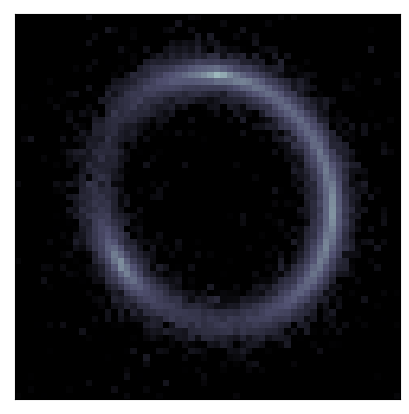

In [8]:
# plot the image
cmap_string = 'bone'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -2
v_max = 1

f, ax = plt.subplots(1, 1, figsize=(5,5), sharex=False, sharey=False)
im = ax.matshow(np.log10(image_noisy), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

## Fit the image  <a name="analyse_image"></a>

[Back to contents](#contents)

### Priors and reference pdfs
While `Cobaya` has the ability to use any continuous 1D distribution from `scipy.stats` as a prior, currently only uniform priors are available in the `lenstronomy` implementation. The prior boundaries are defined by the `kwargs_lower_*` and `kwargs_upper_*` dicts, just as they are in `emcee`.

Besides the prior, `Cobaya` also allows us to define the region where most of the prior mass is expected, which is called the reference pdf. Making a good choice of reference pdf will speed up the sampling, as the initial point in the chain will be drawn from it rather than from the prior, which is likely to decrease burn-in time.

Again, `Cobaya` allows any continuous 1D distribution as a reference pdf, but the `lenstronomy` implementation currently only has a Gaussian pdf available. The mean and standard deviation of the Gaussian reference pdf for each parameter is defined by the `kwargs_*_init` and `kwargs_*_sigma` dicts. 

**Caution**: make sure the standard deviation of your reference pdf is not too large; in combination with a large [proposal width](#widths) this can result in the algorithm trying to take steps outside the prior, which will always be rejected. `Cobaya` will automatically halt the sampling if a certain number of steps have been rejected in a row (the default is 100 times the number of parameters, but this can be increased, see `kwargs_cobaya`).

In [9]:
# lens
lens_model_list = ['SIS', 'LOS_MINIMAL']

# initialise the lists of parameters
kwargs_lens_init=[]
kwargs_lens_sigma=[]
fixed_lens = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# fixed SIS parameters
fixed_lens.append({'center_x': x_lens, 'center_y': y_lens})

# mean and stdev of reference pdf
kwargs_lens_init.append({'theta_E': theta_E})
kwargs_lens_sigma.append({'theta_E': 0.01})

# min/max of prior
kwargs_lower_lens.append({'theta_E': 1.0})
kwargs_upper_lens.append({'theta_E': 3.0})

# fixed LOS parameters
fixed_lens.append({'kappa_od': 0.0, 'omega_od': 0.0, 'kappa_los': 0.0, 'omega_los': 0.0})

# mean and stdev of reference pdfs
kwargs_lens_init.append({'gamma1_od': kwargs_los['gamma1_od'], 'gamma2_od': kwargs_los['gamma2_od'],
                        'gamma1_los': kwargs_los['gamma1_los'], 'gamma2_los': kwargs_los['gamma2_los']})

kwargs_lens_sigma.append({'gamma1_od': 0.01, 'gamma2_od': 0.01,'gamma1_los': 0.01, 'gamma2_los': 0.01})

# min/max of priors
kwargs_lower_lens.append({'gamma1_od': -0.5, 'gamma2_od': -0.5, 'gamma1_los': -0.5, 'gamma2_los': -0.5})
kwargs_upper_lens.append({'gamma1_od': 0.5, 'gamma2_od': 0.5, 'gamma1_los': 0.5, 'gamma2_los': 0.5})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

In [10]:
# source
source_model_list = ['SERSIC']

kwargs_source_init=[]
kwargs_source_sigma=[]
fixed_source = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})

# mean and stdev of reference pdfs
kwargs_source_init.append({'center_x': x_source,
                           'center_y': y_source,
                           'R_sersic': R_sersic_source,
                           'n_sersic': n_sersic_source})

kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01,
                            'R_sersic': 0.01, 'n_sersic': 0.01})

# min/max of priors
kwargs_lower_source.append({'center_x': -1.0, 'center_y': -1.0,
                            'R_sersic': 0.0, 'n_sersic': 0.0})

kwargs_upper_source.append({'center_x': 1.0, 'center_y': 1.0,
                            'R_sersic': 10.0, 'n_sersic': 6.0})

source_params = [kwargs_source_init, kwargs_source_sigma,
                 fixed_source, kwargs_lower_source, kwargs_upper_source]

### Other `lenstronomy` settings
- `kwargs_params`:  gather the lens and light model parameters.
- `kwargs_model`: gather the lens and light models.
- `kwargs_likelihood`: ...
- `kwargs_data_joint`: ...
- `kwargs_constraints`: keyword arguments of the Param() class to handle parameters and settings of the likelihood.

In [11]:
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params}

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list}

kwargs_likelihood = {'source_marg': True}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'single-band'}

kwargs_constraints = {}

### LaTeX labels
We also need to pass some LaTeX labels for the parameters to `Cobaya`, if we want to use `GetDist` for contour plots (see [below](#contour)). If you don't pass these labels, `Cobaya` will use the internal `lenstronomy` parameter names e.g. `theta_E_lens0`. The double underscore can break plotting routines which expect LaTeX inputs.

In [12]:
labels = [# SIS
          r'\theta_{\rm E}',
          # LOS
          r'\gamma_1^{\rm od}',
          r'\gamma_2^{\rm od}',
          r'\gamma_1^{\rm LOS}',
          r'\gamma_2^{\rm LOS}',
          # source
          r'R_{\rm S\acute{e}rsic}',
          r'n_{\rm S\acute{e}rsic}',
          r'x_{\rm source}',
          r'y_{\rm source}']

### The proposal widths <a name="widths"></a>
`Cobaya` optionally takes a list of proposal widths i.e. the size of the expected conditional (not marginalised) posterior width for each parameter. Unlike ensemble methods, a pure Metropolis--Hastings MCMC algorithm is quite sensitive to this choice. Typically, if you overestimate the proposal width, the algorithm will attempt to make very large steps in parameter space, which are likely to approach the edges of the prior or attempt to move beyond it, and will thus be rejected. `Cobaya` will halt the sampling if no steps are accepted after a certain number of attempts: the default is currently 100 times the number of parameters, but if necessary this can be increased (even to infinity) by passing `max_tries` in `kwargs_cobaya`.

It is thus more sensible to *underestimate* the proposal width. `Cobaya` learns and updates the covariance matrix as the sampling progresses, so there is typically no danger of an underestimated proposal width resulting in an underestimated posterior width once the run has converged.

If you don't pass any proposal widths, `Cobaya` will use the width of the prior instead.

You can pass them either as a simple list, 

In [13]:
proposals = [0.001]*len(labels)

or as a dictionary, which is useful if you have many parameters and want to pass different values for each without losing clarity, i.e.

In [14]:
proposals = {# SIS
             'theta_E':    0.001,
             # LOS
             'gamma1_od':  0.001,
             'gamma2_od':  0.001,
             'gamma1_los': 0.001,
             'gamma2_los': 0.001,
             # source
             'R_sersic':   0.001,
             'n_sersic':   0.001,
             'center_x':   0.001,
             'center_y':   0.001}

### Run the fitting sequence

`Cobaya` will run without needing any additional information using default settings, but you can pass plenty of additional keyword arguments to modify its behaviour. For example, here I pass the path where I want to save the products of the sampling (chain files, covariance matrix etc), at what level of convergence the sampling should stop, and whether or not to overwrite any previous products which have the same name. 

Note that there are many additional options beyond these. For the full list of settings and what they do, see the [`Cobaya` docs](https://cobaya.readthedocs.io/en/latest/sampler_mcmc.html#options-and-defaults). If you don't specify any of these options, `Cobaya` will use the default settings/values listed in the docs.

In [15]:
# initialise the fitting sequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params)

# additional kwargs for Cobaya
kwargs_cobaya = {'latex': labels, 
                 'proposal_widths': proposals,
                 'Rminus1_stop': 0.01, # sampling stops when Gelman--Rubin criterion (R-1) < 0.01
                 'path': root, # saves the chain file 'demo.1.txt' to the 'chains' folder
                 'force_overwrite': True # overwrites any previously saved chain with the same name
                }


fitting_kwargs_list = [['metropolis_hastings', kwargs_cobaya]]

# run the MCMC
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

# get the result
kwargs_result = chain_list[0][2]

Using the Metropolis--Hastings MCMC sampler in Cobaya.
[output] Output to be read-from/written-into folder 'chains', with prefix 'demo'
[output] Found existing info files with the requested output prefix: 'chains/demo'
[output] Will delete previous products ('force' was requested).
[lenstronomy_likelihood] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {lenstronomy_likelihood: 460.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: theta_E_lens0:1.483332, gamma1_od_lens1:0.01186417, gamma2_od_lens1:0.01749432, gamma1_los_lens1:-0.04192276, gamma2_los_lens1:-0.03583487, R_sersic_source_light0:0.3090022, n_sersic_source_light0:2.98661, center_x_source_light0:0.08765828, center_y_source_light0:0.09184715
[mcmc] Sampling!
[mcmc

[mcmc]  - Convergence of means: R-1 = 0.074833 after 9792 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12600 samples accepted.
[mcmc]  - Acceptance rate: 0.612
[mcmc]  - Convergence of means: R-1 = 0.052046 after 10080 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12960 samples accepted.
[mcmc]  - Acceptance rate: 0.612
[mcmc]  - Convergence of means: R-1 = 0.070091 after 10368 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13320 samples accepted.
[mcmc]  - Acceptance rate: 0.611
[mcmc]  - Convergence of means: R-1 = 0.089614 after 10656 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13680 samples accepted.
[mcmc]  - Acceptance rate: 0.610
[mcmc]  - Convergence of means: R-1 = 0.085433 after 10944 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[m

[mcmc]  - Acceptance rate: 0.591
[mcmc]  - Convergence of means: R-1 = 0.040285 after 20736 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 26280 samples accepted.
[mcmc]  - Acceptance rate: 0.590
[mcmc]  - Convergence of means: R-1 = 0.037201 after 21024 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 26640 samples accepted.
[mcmc]  - Acceptance rate: 0.590
[mcmc]  - Convergence of means: R-1 = 0.033612 after 21312 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 27000 samples accepted.
[mcmc]  - Acceptance rate: 0.591
[mcmc]  - Convergence of means: R-1 = 0.031798 after 21600 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 27360 samples accepted.
[mcmc]  - Acceptance rate: 0.591
[mcmc]  - Convergence of means: R-1 = 0.028649 after 21888 accepted steps
[mcmc]  - Updated cov

[mcmc] Learn + convergence test @ 39600 samples accepted.
[mcmc]  - Acceptance rate: 0.589
[mcmc]  - Convergence of means: R-1 = 0.014666 after 31680 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 39960 samples accepted.
[mcmc]  - Acceptance rate: 0.588
[mcmc]  - Convergence of means: R-1 = 0.013113 after 31968 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40320 samples accepted.
[mcmc]  - Acceptance rate: 0.588
[mcmc]  - Convergence of means: R-1 = 0.012621 after 32256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 40680 samples accepted.
[mcmc]  - Acceptance rate: 0.588
[mcmc]  - Convergence of means: R-1 = 0.013490 after 32544 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 41040 samples accepted.
[mcmc]  - Acceptance rate: 0.588
[mcmc]  - Convergence of means: R-1 =

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 53280 samples accepted.
[mcmc]  - Acceptance rate: 0.588
[mcmc]  - Convergence of means: R-1 = 0.014554 after 42624 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 53640 samples accepted.
[mcmc]  - Acceptance rate: 0.588
[mcmc]  - Convergence of means: R-1 = 0.015900 after 42912 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 54000 samples accepted.
[mcmc]  - Acceptance rate: 0.588
[mcmc]  - Convergence of means: R-1 = 0.016025 after 43200 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 54360 samples accepted.
[mcmc]  - Acceptance rate: 0.588
[mcmc]  - Convergence of means: R-1 = 0.015079 after 43488 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 54720 samples accepted.
[mcmc]  - Accepta

### Results<a name="results"></a>
[Back to contents](#contents)

We can use `Cobaya` to plot the progress of the chain i.e. the Gelman--Rubin criterion (R-1) and the acceptance rate. If the acceptance rate is high (>0.5) from the beginning of the run, you may want to try increasing the proposal widths slightly as it's a sign that the sampling is proceeding "too easily" and may therefore be stuck in a local minimum of the log-likelihood.

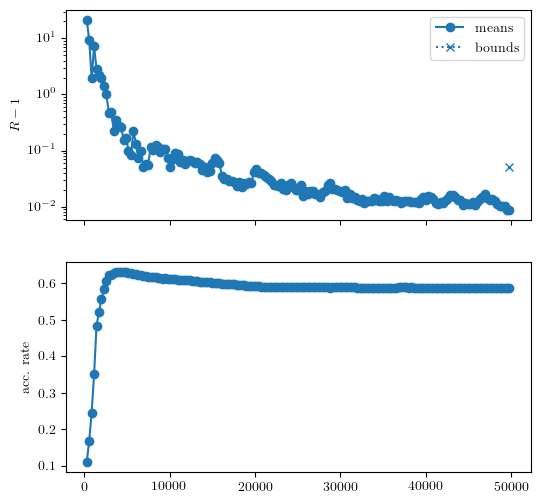

In [16]:
plot_progress(path+root, figure_kwargs={'figsize': (6,6)})
plt.show()

We can use the `kwargs_result` to make the usual `lenstronomy` ModelPlot.

-0.9890976801164917 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9890976801164917


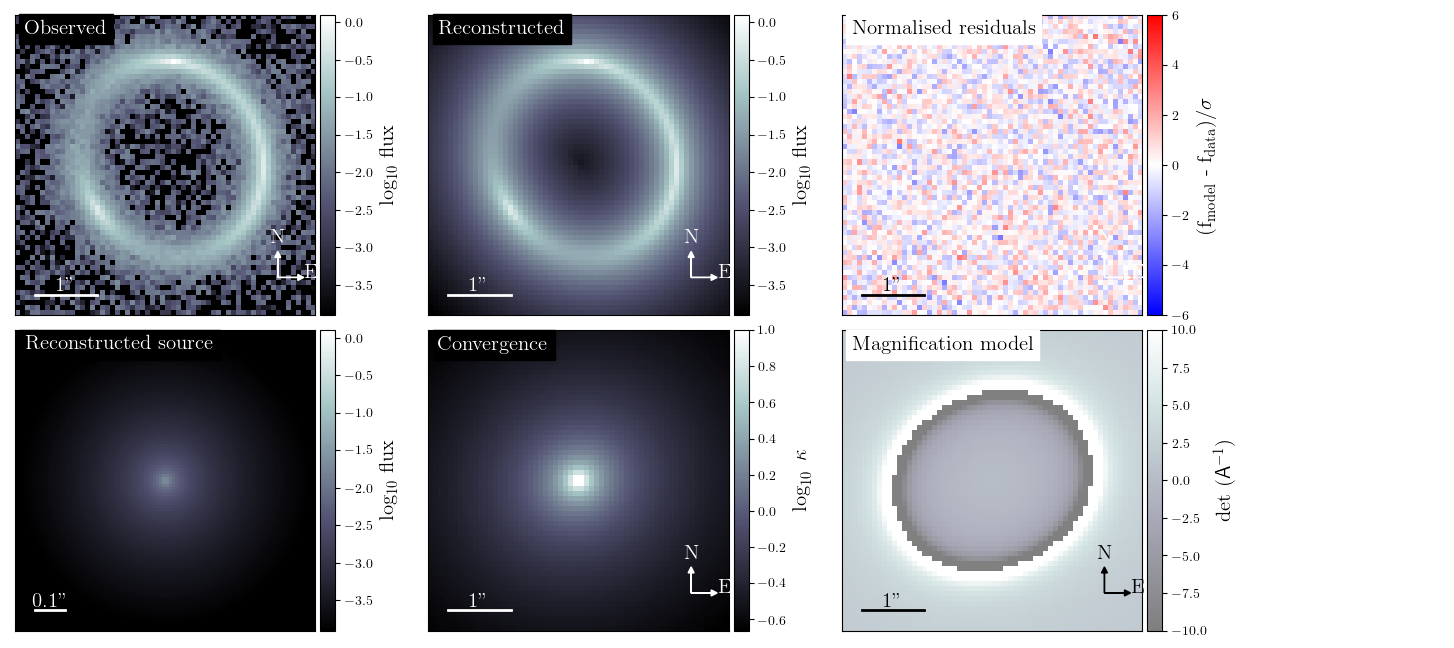

In [17]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result,
                      arrow_size=0.02, cmap_string='bone')
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, text='Normalised residuals')
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.show()

### Contour plot <a name="contour"></a>
[Back to contents](#contents)

We can use `GetDist` to make some nice contour plots (see the [`GetDist` plot gallery](https://getdist.readthedocs.io/en/latest/plot_gallery.html) for all kinds of plotting possibilities). Note that I remove the burn-in from the chain before plotting via the `ignore_rows` keyword argument; in this case I'm removing the first 30% which is usually more than sufficient.

<Figure size 600x600 with 0 Axes>

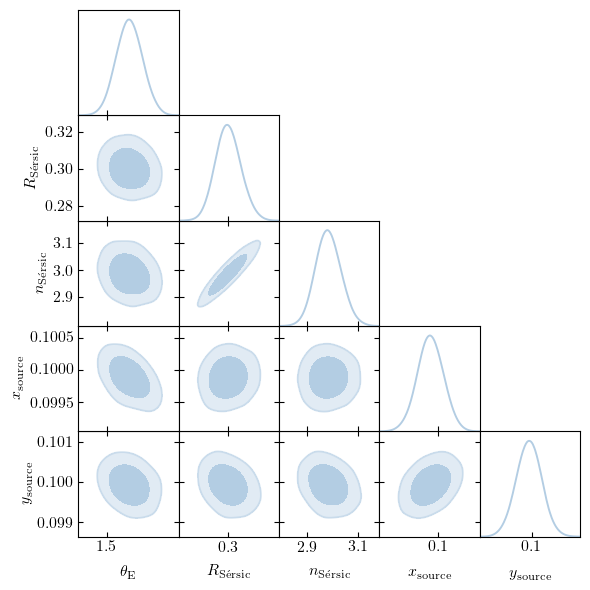

In [18]:
# plot some contours using getdist
g = gdplt.get_single_plotter(chain_dir = path, analysis_settings={'ignore_rows':0.3}, width_inch=6, ratio=1)

g.settings.axes_fontsize=16
g.settings.axes_labelsize=16
g.settings.linewidth_contour = 4
g.settings.linewidth = 4

# we have to give it the lenstronomy names here, but it will use the LaTeX labels in the plot
plot_params = ['theta_E_lens0', 'R_sersic_source_light0','n_sersic_source_light0', 
               'center_x_source_light0', 'center_y_source_light0']

g.triangle_plot(roots=['demo'], params=plot_params, filled=True, contour_colors = ['#b3cde3'])

plt.show()

<Figure size 600x600 with 0 Axes>

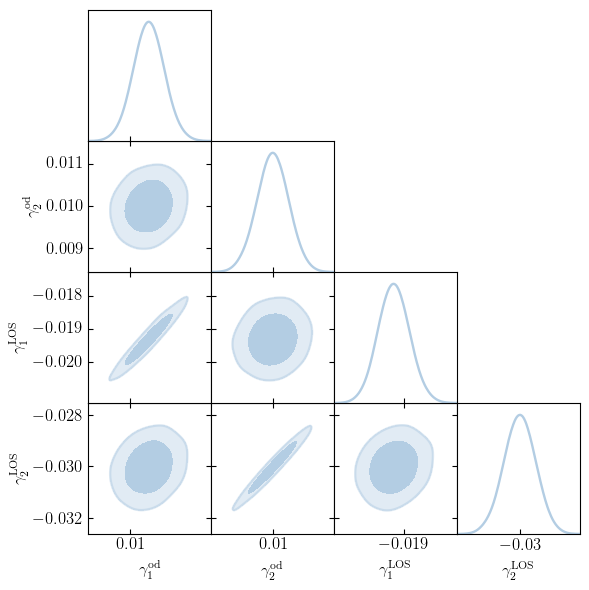

In [19]:
g = gdplt.get_single_plotter(chain_dir = path, analysis_settings={'ignore_rows':0.3}, width_inch=6, ratio=1)

g.settings.axes_fontsize=16
g.settings.axes_labelsize=16
g.settings.linewidth_contour = 4
g.settings.linewidth = 4

plot_params = ['gamma1_od_lens1', 'gamma2_od_lens1', 
               'gamma1_los_lens1', 'gamma2_los_lens1']

g.triangle_plot(roots=['demo'], params=plot_params, filled=True, contour_colors = ['#b3cde3'])

plt.show()

### Running with previously generated covariance matrix <a name="covmat"></a>
[Back to contents](#contents)

`Cobaya` automatically generates a covariance matrix for each run, which can be used to initialise and potentially speed up subsequent runs, for example if you're now fitting with a lens model which includes a couple of additional parameters. Let's now fit our image with an SIE lens profile, so we have two additional parameters -- the components of the ellipticity -- in the game. We'll pass the covmat file generated during the previous run to `Cobaya`.

In [20]:
# lens; fit with SIE instead of SIS
lens_model_list = ['SIE', 'LOS_MINIMAL']

# initialise the lists of parameters
kwargs_lens_init=[]
kwargs_lens_sigma=[]
fixed_lens = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({'center_x': x_lens, 'center_y': y_lens})

# mean and stdev of reference pdfs; now with ellipticity parameters
kwargs_lens_init.append({'theta_E': theta_E, 'e1': 0.0, 'e2': 0.0})
kwargs_lens_sigma.append({'theta_E': 0.01, 'e1': 0.01, 'e2': 0.01})

# min/max of prior; now with ellipticity parameters
kwargs_lower_lens.append({'theta_E': 1.0, 'e1': -0.1, 'e2': -0.1})
kwargs_upper_lens.append({'theta_E': 3.0, 'e1': 0.1, 'e2': 0.1})

# fixed LOS parameters
# with an ellipticity component in play we can keep the od shear fixed to zero 
# without affecting the inference on the LOS shear
# see section 3.1.2 of 2210.07210 for more info
fixed_lens.append({'gamma1_od': 0.0, 'gamma2_od': 0.0, 
                   'kappa_od': 0.0, 'omega_od': 0.0, 
                   'kappa_los': 0.0, 'omega_los': 0.0})

# mean and stdev of reference pdfs
kwargs_lens_init.append({'gamma1_los': kwargs_los['gamma1_los'], 'gamma2_los': kwargs_los['gamma2_los']})

kwargs_lens_sigma.append({'gamma1_los': 0.01, 'gamma2_los': 0.10})

# min/max of priors
kwargs_lower_lens.append({'gamma1_los': -0.5, 'gamma2_los': -0.5})
kwargs_upper_lens.append({'gamma1_los': 0.5, 'gamma2_los': 0.5})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# the source model and the rest of the lenstronomy settings stay the same as before
kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params}

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list}

In [21]:
labels = [# SIE
          r'\theta_{\rm E}',
          r'e_1',
          r'e_2',
          # LOS
          r'\gamma_1^{\rm LOS}',
          r'\gamma_2^{\rm LOS}',
          # source
          r'R_{\rm S\acute{e}rsic}',
          r'n_{\rm S\acute{e}rsic}',
          r'x_{\rm source}',
          r'y_{\rm source}']

In [22]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params)

# note we don't need to pass 'proposals' when we have a covmat (Cobaya will ignore them)
kwargs_cobaya = {'latex': labels,
                 'covmat': 'chains/demo.covmat', # covmat from previous run
                 'Rminus1_stop': 0.01,
                 'max_tries': np.inf,
                 'path': 'chains/demo_with_covmat', # new name for new run with covmat
                 'force_overwrite': True}

fitting_kwargs_list = [['metropolis_hastings', kwargs_cobaya]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

Using the Metropolis--Hastings MCMC sampler in Cobaya.
[output] Output to be read-from/written-into folder 'chains', with prefix 'demo_with_covmat'
[output] Found existing info files with the requested output prefix: 'chains/demo_with_covmat'
[output] Will delete previous products ('force' was requested).
[lenstronomy_likelihood] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {lenstronomy_likelihood: 561.0}
[mcmc] Covariance matrix loaded for params ['theta_E_lens0', 'gamma1_los_lens1', 'gamma2_los_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'center_x_source_light0', 'center_y_source_light0']
[mcmc] Missing proposal covariance for params ['e1_lens0', 'e2_lens0']
[mcmc] Covariance matrix not complete. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial poi

[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 11520 samples accepted.
[mcmc]  - Acceptance rate: 0.292
[mcmc]  - Convergence of means: R-1 = 0.124608 after 9216 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 11880 samples accepted.
[mcmc]  - Acceptance rate: 0.304
[mcmc]  - Convergence of means: R-1 = 0.112290 after 9504 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12240 samples accepted.
[mcmc]  - Acceptance rate: 0.318
[mcmc]  - Convergence of means: R-1 = 0.108970 after 9792 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12600 samples accepted.
[mcmc]  - Acceptance rate: 0.333
[mcmc]  - Convergence of means: R-1 = 0.100871 after 10080 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 12960 samples accepted.
[mcmc]  - Acceptance

[mcmc]  - Convergence of means: R-1 = 0.074398 after 19872 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 25200 samples accepted.
[mcmc]  - Acceptance rate: 0.550
[mcmc]  - Convergence of means: R-1 = 0.072124 after 20160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 25560 samples accepted.
[mcmc]  - Acceptance rate: 0.552
[mcmc]  - Convergence of means: R-1 = 0.067083 after 20448 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 25920 samples accepted.
[mcmc]  - Acceptance rate: 0.556
[mcmc]  - Convergence of means: R-1 = 0.066268 after 20736 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 26280 samples accepted.
[mcmc]  - Acceptance rate: 0.558
[mcmc]  - Convergence of means: R-1 = 0.070890 after 21024 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[

[mcmc] Learn + convergence test @ 38520 samples accepted.
[mcmc]  - Acceptance rate: 0.590
[mcmc]  - Convergence of means: R-1 = 0.016443 after 30816 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 38880 samples accepted.
[mcmc]  - Acceptance rate: 0.590
[mcmc]  - Convergence of means: R-1 = 0.017001 after 31104 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 39240 samples accepted.
[mcmc]  - Acceptance rate: 0.590
[mcmc]  - Convergence of means: R-1 = 0.018237 after 31392 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 39600 samples accepted.
[mcmc]  - Acceptance rate: 0.590
[mcmc]  - Convergence of means: R-1 = 0.015865 after 31680 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 39960 samples accepted.
[mcmc]  - Acceptance rate: 0.590
[mcmc]  - Convergence of means: R-1 =

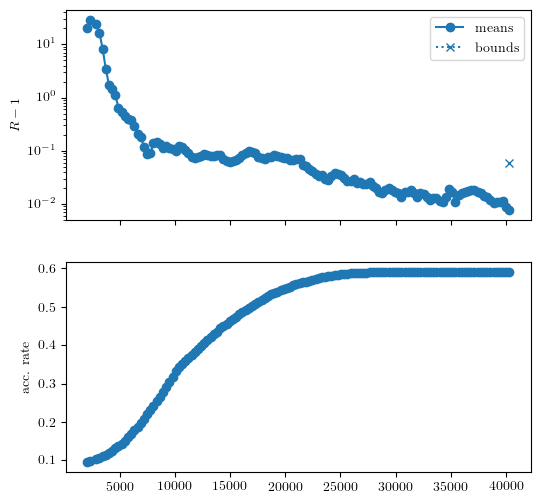

In [23]:
plot_progress('chains/demo_with_covmat', figure_kwargs={'figsize': (6,6)})
plt.show()

-0.989789659062288 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.989789659062288


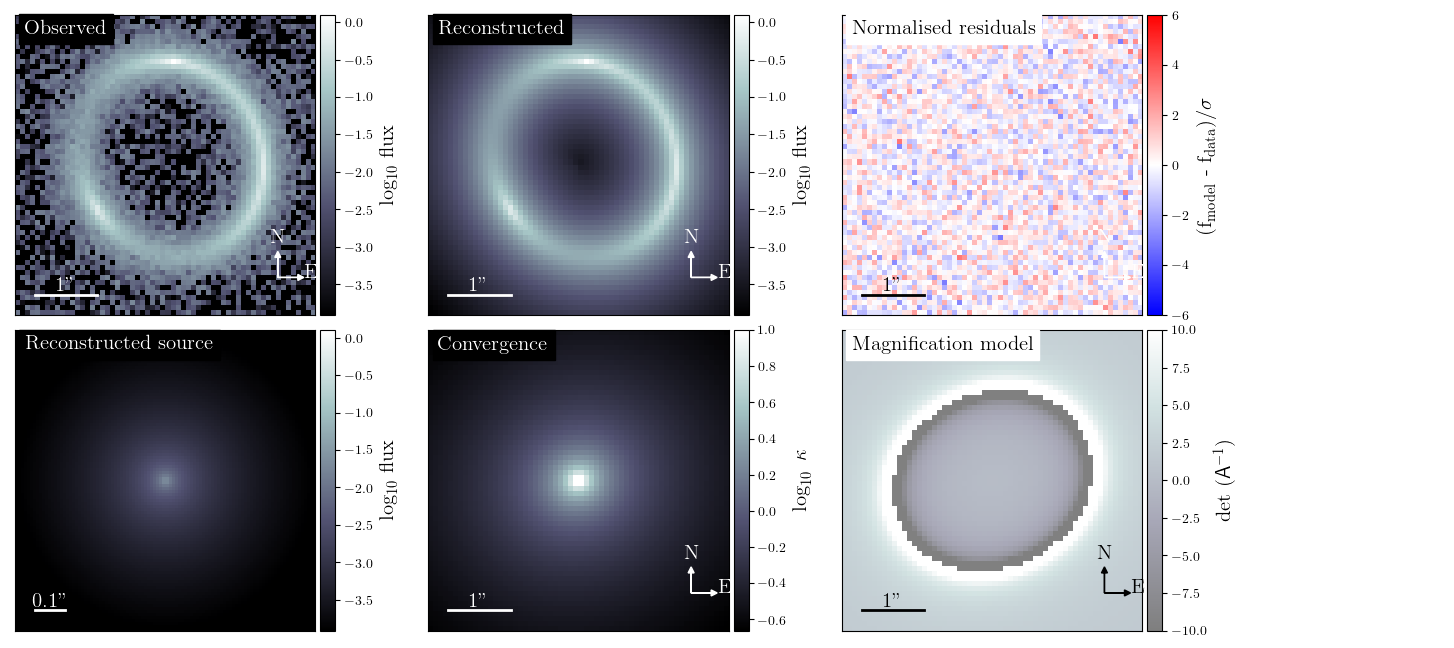

In [27]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, chain_list[0][2],
                      arrow_size=0.02, cmap_string='bone')
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, text='Normalised residuals')
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.show()

<Figure size 600x600 with 0 Axes>

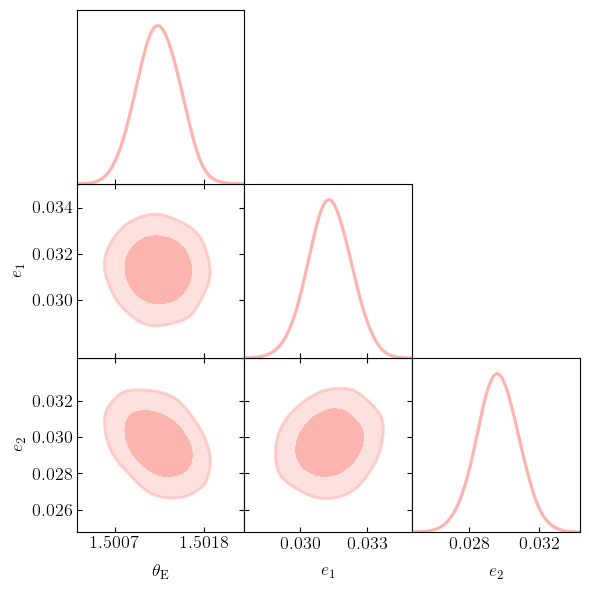

In [25]:
g = gdplt.get_single_plotter(chain_dir = path, analysis_settings={'ignore_rows':0.3}, width_inch=6, ratio=1)

g.settings.axes_fontsize=16
g.settings.axes_labelsize=16
g.settings.linewidth_contour = 4
g.settings.linewidth = 4

plot_params = ['theta_E_lens0', 'e1_lens0', 'e2_lens0']

g.triangle_plot(roots=['demo_with_covmat'], params=plot_params, filled=True, contour_colors = ['#fbb4ae'])

plt.show()

<Figure size 600x600 with 0 Axes>

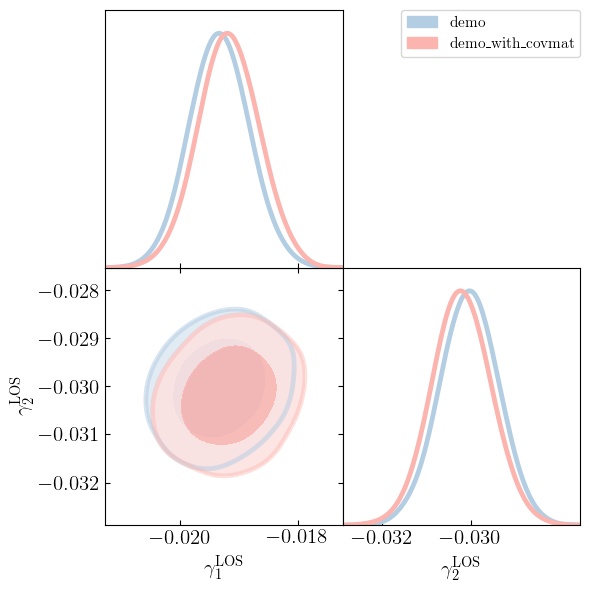

In [26]:
g = gdplt.get_single_plotter(chain_dir = path, analysis_settings={'ignore_rows':0.3}, width_inch=6, ratio=1)

g.settings.axes_fontsize=16
g.settings.axes_labelsize=16
g.settings.linewidth_contour = 4
g.settings.linewidth = 4

plot_params = ['gamma1_los_lens1', 'gamma2_los_lens1']

g.triangle_plot(roots=['demo', 'demo_with_covmat'], 
                params=plot_params, 
                filled=True, 
                contour_colors = ['#b3cde3', '#fbb4ae'])

plt.show()

### Interpretation of results
Notice how there was no ellipticity included in the original lens model (SIS), but there was external shear, encoded in the `gamma_od` and `gamma_LOS` parameters. When we fit using the SIE model, we added the two additional ellipticity parameters, but kept the `gamma_od` shear parameters fixed to zero. This is because an almost perfect degeneracy exists between these sets of parameters. We can see that even though there was no ellipticity in the original model, our inference using the SIE model produces very distinctly non-zero measurements of the ellipticity parameters. If we had included the `gamma_od` shear along with the SIE model, we would have seen a very strong degeneracy in the joint posterior distributions of these parameters. 

This result highlights the value of the line-of-sight shear, `gamma_LOS`. This definition of the shear evades any such degeneracy with lens model parameters, and we can clearly see that the inference on this parameter does not significantly change when we change the model with which we fit.

For more information about the line-of-sight shear, see [Line-of-sight effects in strong gravitational lensing ](https://arxiv.org/abs/2104.08883) and [Measuring line-of-sight shear with Einstein rings: a proof of concept](https://arxiv.org/abs/2210.07210).

### Running `Cobaya` in parallel using MPI <a name="mpi"></a>
The `Cobaya` implementation in `lenstronomy` allows you to run multiple chains in parallel using MPI. The simplest way to do this is to copy this notebook into a Python script, pass `'mpi': True` in your `kwargs_cobaya`, and run the script in your terminal (or submit a batch job to a cluster) with `mpirun`:

<code> mpirun -n 2 python cobaya_demo.py </code>

You can change the number of processes used according to the specifications of the machine.

Note: to copy multiple jupyter cells at once, press `esc` then `shift + up/down` to select multiple cells, then `ctrl + c` or `cmd + c`.

[Back to contents](#contents)